# Train a stardist neural network for segmentation

In [35]:
from skimage.io import imread, imsave
from tnia.plotting.projections import show_xyz_slice, show_xyz_max, show_xy_zy_max
from random import randint
import numpy as np
import os
from skimage.measure import label
from stardist import calculate_extents

# Get the list of visible devices and confirm that GPU is available 

... or else training will take a long time

In [36]:
import tensorflow as tf
visible_devices = tf.config.list_physical_devices()
print(visible_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Define model path

This is the path where the model will be saved, change to be local to your machine

In [3]:
parent_dl_path=get_parent_dl_path()
model_path = os.path.join(parent_dl_path, r'models')
print(model_path)
patches_path = os.path.join(parent_dl_path, r'patches')
print(patches_path)

NameError: name 'get_parent_dl_path' is not defined

# Load the corrupted images and ground truth images

5 1117
0.0 4914.01
1 798
0.0 2284.8398
17 2265
0.0 4970.25
3 1231
0.0 5314.4097
2 2100
0.0 5520.4897
3 1226
0.0 4774.81
5 1924
0.0 5184.0
3 1588
0.0 6384.01
4 892
0.0 1874.89
2 643
0.0 2007.0399
10 1676
0.0 3819.24
5 2043
0.0 4529.29
7 1663
0.0 4096.0
4 926
0.0 2070.25
13 924
0.0 1962.49
12 1902
0.0 4970.25
0 155
0.0 249.64
10 2291
0.0 5358.2397
1 145
0.0 576.0
15 2720
0.0 6384.01
(20, 16, 128, 128) (20, 16, 128, 128)
float32 uint16


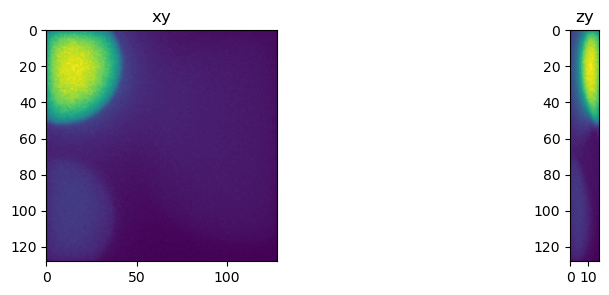

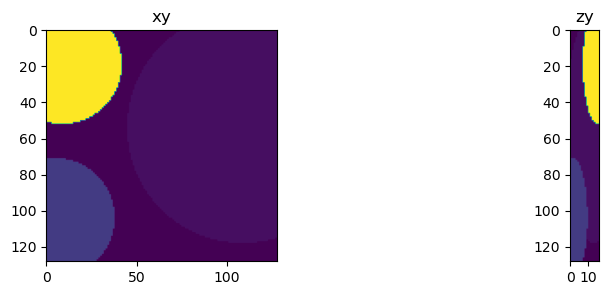

In [37]:
corrupted_dir = r"D:\images\deep-learning\big_spheres\train\images"
ground_truth_dir = r"D:\images\deep-learning\big_spheres\train\ground truth"
corrupted_files = os.listdir(corrupted_dir)
ground_truth_files = os.listdir(ground_truth_dir)

# Preprocess the images
X = []
Y = []
for i in range(len(corrupted_files)):
    # Load the corrupted image and ground truth image
    corrupted_img = imread(os.path.join(corrupted_dir, corrupted_files[i]), plugin='tifffile')
    ground_truth_img = imread(os.path.join(ground_truth_dir, ground_truth_files[i]), plugin='tifffile')
    # Resize the images to the desired size
    #corrupted_img = np.reshape(corrupted_img, (256, 256, 100, 1))
    #ground_truth_img = np.reshape(ground_truth_img, (256, 256, 100, 1))
    
    corrupted_img = corrupted_img[..., np.newaxis]
    ground_truth_img = ground_truth_img[..., np.newaxis]
    
    print(corrupted_img.min(), corrupted_img.max())
    print(ground_truth_img.min(), ground_truth_img.max())

    # Normalize the pixel values to [0, 1]
    corrupted_img = (corrupted_img.astype('float32')-corrupted_img.min()) / (corrupted_img.max() - corrupted_img.min())
    #ground_truth_img = (ground_truth_img.astype('float32')-ground_truth_img.min()) / (ground_truth_img.max() - ground_truth_img.min()) 
    
    # Append the preprocessed images to the training set
    X.append(corrupted_img)
    Y.append(ground_truth_img)
X = np.array(X)
Y = np.array(Y)

X = X.squeeze()
Y = Y.squeeze()
Y = Y.astype('uint16')

print(X.shape, Y.shape)
print(X.dtype, Y.dtype)

fig = show_xy_zy_max(X[0])
fig = show_xy_zy_max(Y[0])

## Import Stardist

In [38]:
from tnia.deeplearning.stardist_helper import get_stardist_configuration
from stardist.models import Config3D, StarDist3D

In [39]:
extents = calculate_extents(Y.squeeze().astype('uint16'))
anisotropy = tuple(np.max(extents) / extents)

print('extents', extents)
print('anisotropy', anisotropy)

extents [14.25 74.   66.5 ]
anisotropy (5.192982456140351, 1.0, 1.112781954887218)


In [40]:
Y.dtype

dtype('uint16')

In [41]:
from stardist import Rays_GoldenSpiral

n_channel_in =1
axes = 'ZYX'

n_rays = 96 

# Use rays on a Fibonacci lattice adjusted for measured anisotropy of the training data
rays = Rays_GoldenSpiral(n_rays, anisotropy=anisotropy)

# create a csbdeep config
# we mostly use the default settings except in this case unet_n_depth=4, so we downsampling 4 times and can use low level features
# consider changing the number of filters (unet_n_first) to save memory

config = Config3D (rays=rays, axes=axes,n_channel_in=1, train_patch_size = (16,128,128), anisotropy=anisotropy, grid=(1,4,4), unet_n_depth=3)

#config = Config(axes, n_channel_in, n_channel_out, train_steps_per_epoch=20, train_epochs=50, unet_n_depth=4)
#print(config)
new_model = True

if new_model:
    #model = StarDist3D(config, name='stardist_model_48ray_combined', basedir=model_path)
    print('initializing new model')
    model = StarDist3D(config, name='stardist_big', basedir='C:\\Users\\bnort\\work\\ImageJ2022\\tnia\\models363')
else:
    model = StarDist3D(None, name='stardist_model_Sep_22_new_labels', basedir='C:\\Users\\bnort\\work\\ImageJ2022\\tnia\\models363')
vars(config)

initializing new model
Using default values: prob_thresh=0.5, nms_thresh=0.4.


{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 97,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 96,
 'grid': (1, 4, 4),
 'anisotropy': (5.192982456140351, 1.0, 1.112781954887218),
 'backbone': 'unet',
 'rays_json': {'name': 'Rays_GoldenSpiral',
  'kwargs': {'n': 96,
   'anisotropy': (5.192982456140351, 1.0, 1.112781954887218)}},
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, None, 1),
 'net_mask_shape': (None, None, None, 1),
 'train_patch_size': (16, 128, 128),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae'

In [42]:
config.anisotropy, config.grid
median_size = calculate_extents(Y[1:2], np.median)
fov = np.array(model._axes_tile_overlap('ZYX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [14. 74. 58.]
network field of view :  [ 32 128 128]


In [43]:
X_train=X[3:]
Y_train=Y[3:]
X_val=X[:3]
Y_val=Y[:3]


In [44]:
model.train(X_train, Y_train, validation_data=(X_val,Y_val),epochs=10, steps_per_epoch=50)

Epoch 1/10
50/50 [==============================] - 52s 988ms/step - loss: 6.1917 - prob_loss: 0.5402 - dist_loss: 28.2578 - prob_kld: 0.2712 - dist_relevant_mae: 28.2578 - dist_relevant_mse: 1252.0479 - dist_dist_iou_metric: 4.8221e-04 - val_loss: 6.3097 - val_prob_loss: 0.5252 - val_dist_loss: 28.9225 - val_prob_kld: 0.2323 - val_dist_relevant_mae: 28.9223 - val_dist_relevant_mse: 1341.1978 - val_dist_dist_iou_metric: 0.0060 - lr: 3.0000e-04
Epoch 2/10
50/50 [==============================] - 62s 1s/step - loss: 4.7368 - prob_loss: 0.5639 - dist_loss: 20.8646 - prob_kld: 0.2926 - dist_relevant_mae: 20.8635 - dist_relevant_mse: 821.8854 - dist_dist_iou_metric: 0.1652 - val_loss: 4.1756 - val_prob_loss: 0.5490 - val_dist_loss: 18.1332 - val_prob_kld: 0.2561 - val_dist_relevant_mae: 18.1320 - val_dist_relevant_mse: 669.7757 - val_dist_dist_iou_metric: 0.2020 - lr: 3.0000e-04
Epoch 3/10
50/50 [==============================] - 58s 1s/step - loss: 3.5330 - prob_loss: 0.5102 - dist_loss: 1

In [45]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((17, 16, 128, 128), (17, 16, 128, 128), (3, 16, 128, 128), (3, 16, 128, 128))

In [46]:
labels.mean()

0.5148696899414062

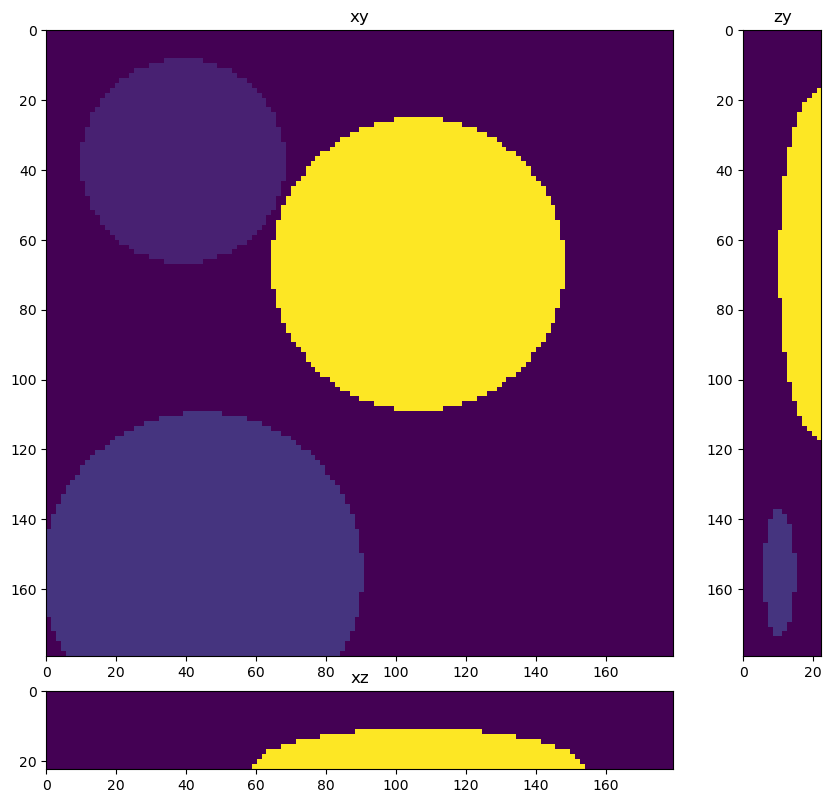

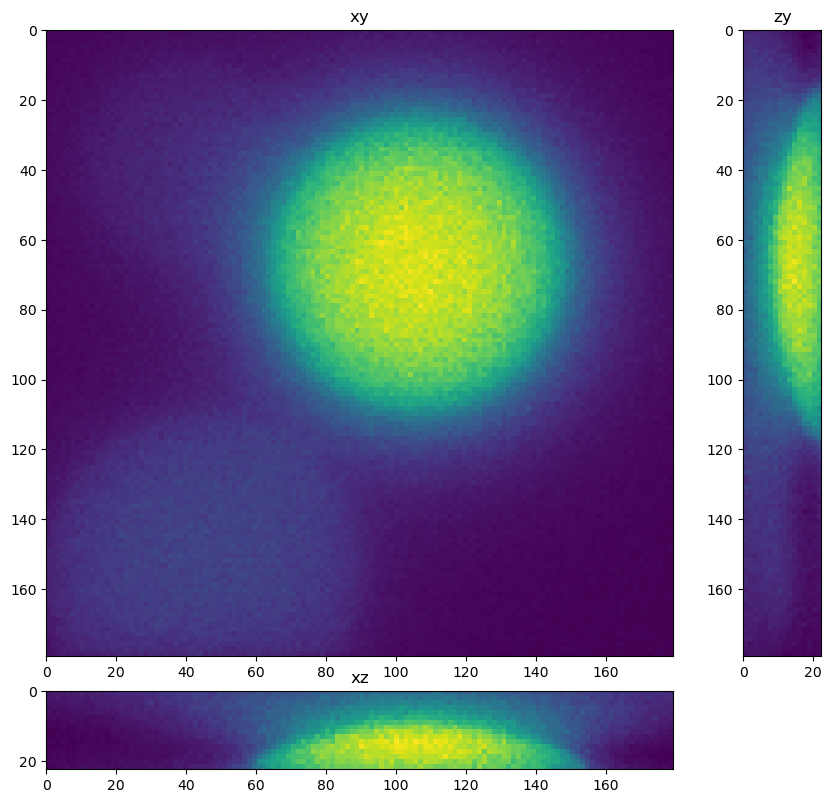

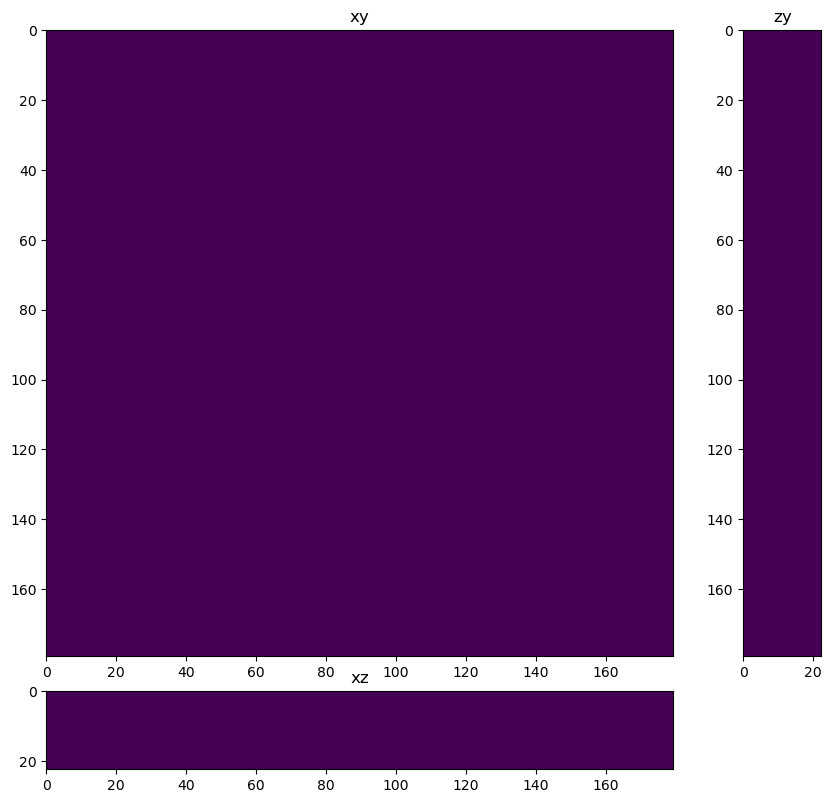

In [48]:
n=2
labels, details = model.predict_instances(X_train[n], prob_thresh=0.5, nms_thresh=0.5)
fig = show_xyz_slice(Y_train[n], int(Y_train[0].shape[2]/2), int(Y_train[0].shape[1]/2), 10,1.4,1.4)
fig = show_xyz_slice(X_train[n], int(X_train[0].shape[2]/2), int(X_train[0].shape[1]/2), 10,1.4,1.4)
fig = show_xyz_slice(labels, int(labels.shape[2]/2), int(labels.shape[1]/2), 10,1.4,1.4)

In [23]:
import napari
viewer = napari.Viewer()
viewer.add_image(X_train[n])
viewer.add_labels(labels)
viewer.add_labels(Y_train[n])
viewer.show()

napari.manifest -> 'napari-hello' could not be imported: Cannot find module 'napari_plugins' declared in entrypoint: 'napari_plugins:napari.yaml'
